In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class ResNet18Encoder(nn.Module):
    """
    ResNet18-based encoder for Deep SVDD
    Modified to remove the final classification layer
    """
    def __init__(self, latent_dim=128):
        super(ResNet18Encoder, self).__init__()

        # Load pretrained ResNet18 and remove the final layer
        resnet = torchvision.models.resnet18(pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC layer

        # Add custom final layers
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class DeepSVDD:
    """
    Deep Support Vector Data Description implementation
    """
    def __init__(self, latent_dim=128, nu=0.1, device='cuda'):
        self.latent_dim = latent_dim
        self.nu = nu  # Outlier fraction parameter
        self.device = device
        self.center = None
        self.radius = None
        self.net = None

    def init_center(self, dataloader, net, eps=0.1):
        """Initialize the center c as the mean of the network outputs"""
        n_samples = 0
        c = torch.zeros(self.latent_dim, device=self.device)

        net.eval()
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(self.device)
                outputs = net(data)
                n_samples += outputs.shape[0]
                c += torch.sum(outputs, dim=0)

        c /= n_samples

        # If center is too close to origin, set it to eps
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps

        return c

    def train(self, dataloader, epochs=100, lr=0.001, weight_decay=1e-6):
        """Train the Deep SVDD model"""
        self.net = ResNet18Encoder(self.latent_dim).to(self.device)

        # Initialize center
        self.center = self.init_center(dataloader, self.net)

        optimizer = optim.Adam(self.net.parameters(), lr=lr, weight_decay=weight_decay)

        self.net.train()
        losses = []

        print("Training Deep SVDD...")
        for epoch in tqdm(range(epochs)):
            epoch_loss = 0
            n_batches = 0

            for data, _ in dataloader:
                data = data.to(self.device)

                optimizer.zero_grad()
                outputs = self.net(data)

                # Deep SVDD loss: minimize distance to center
                dist = torch.sum((outputs - self.center) ** 2, dim=1)
                loss = torch.mean(dist)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                n_batches += 1

            avg_loss = epoch_loss / n_batches
            losses.append(avg_loss)

            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

        # Calculate radius as the (1-nu)-quantile of distances
        self.net.eval()
        distances = []
        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(self.device)
                outputs = self.net(data)
                dist = torch.sum((outputs - self.center) ** 2, dim=1)
                distances.extend(dist.cpu().numpy())

        distances = np.array(distances)
        self.radius = np.quantile(distances, 1 - self.nu)

        return losses

    def predict(self, dataloader):
        """Predict anomaly scores and labels"""
        self.net.eval()
        scores = []

        with torch.no_grad():
            for data, _ in dataloader:
                data = data.to(self.device)
                outputs = self.net(data)
                dist = torch.sum((outputs - self.center) ** 2, dim=1)
                scores.extend(dist.cpu().numpy())

        scores = np.array(scores)
        predictions = (scores > self.radius).astype(int)

        return scores, predictions

def prepare_cifar10_data(normal_class=0, batch_size=128):
    """
    Prepare CIFAR-10 dataset with airplanes as normal class
    normal_class=0 corresponds to airplane class
    """
    # Data transformations
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True, transform=transform_test)

    # Get indices for normal class (airplanes)
    train_normal_idx = [i for i, (_, label) in enumerate(trainset) if label == normal_class]
    test_normal_idx = [i for i, (_, label) in enumerate(testset) if label == normal_class]
    test_anomaly_idx = [i for i, (_, label) in enumerate(testset) if label != normal_class]

    # Use 5000 normal samples for training as mentioned in proposal
    train_normal_idx = train_normal_idx[:5000]

    # Create subsets
    train_normal_set = Subset(trainset, train_normal_idx)
    test_normal_set = Subset(testset, test_normal_idx)
    test_anomaly_set = Subset(testset, test_anomaly_idx)

    # Create data loaders
    train_loader = DataLoader(train_normal_set, batch_size=batch_size, shuffle=True)
    test_normal_loader = DataLoader(test_normal_set, batch_size=batch_size, shuffle=False)
    test_anomaly_loader = DataLoader(test_anomaly_set, batch_size=batch_size, shuffle=False)

    print(f"Training samples (normal): {len(train_normal_set)}")
    print(f"Test samples (normal): {len(test_normal_set)}")
    print(f"Test samples (anomaly): {len(test_anomaly_set)}")

    return train_loader, test_normal_loader, test_anomaly_loader

def extract_features_for_baselines(dataloader, feature_extractor, device):
    """Extract features using a pre-trained model for baseline methods"""
    features = []
    labels = []

    feature_extractor.eval()
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            # Use ResNet18 features before the final layer
            feat = feature_extractor.encoder(data)
            feat = feat.view(feat.size(0), -1)
            features.extend(feat.cpu().numpy())
            labels.extend(target.numpy())

    return np.array(features), np.array(labels)

def train_baseline_models(train_features):
    """Train One-Class SVM and Isolation Forest baseline models"""
    # Standardize features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)

    # One-Class SVM
    oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
    oc_svm.fit(train_features_scaled)

    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    iso_forest.fit(train_features_scaled)

    return oc_svm, iso_forest, scaler

def evaluate_model(y_true, y_pred, scores, model_name):
    """Evaluate model performance"""
    auc = roc_auc_score(y_true, scores)

    print(f"\n{model_name} Results:")
    print(f"AUC-ROC: {auc:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    return auc

def plot_results(deep_svdd_losses, auc_scores):
    """Plot training losses and comparison results"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training loss
    ax1.plot(deep_svdd_losses)
    ax1.set_title('Deep SVDD Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Plot AUC comparison
    models = list(auc_scores.keys())
    aucs = list(auc_scores.values())

    bars = ax2.bar(models, aucs, color=['blue', 'orange', 'green'])
    ax2.set_title('Model Comparison (AUC-ROC)')
    ax2.set_ylabel('AUC-ROC Score')
    ax2.set_ylim(0, 1)

    # Add value labels on bars
    for bar, auc in zip(bars, aucs):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{auc:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def visualize_sample_predictions(test_loader, model, device, num_samples=20):
    """Visualize some sample predictions"""
    model.net.eval()

    # Get some test samples
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Predict
    with torch.no_grad():
        images_gpu = images.to(device)
        outputs = model.net(images_gpu)
        distances = torch.sum((outputs - model.center) ** 2, dim=1)
        predictions = (distances > model.radius).cpu().numpy()
        distances = distances.cpu().numpy()

    # Denormalize images for display
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    # Plot samples
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.ravel()

    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

    for i in range(min(num_samples, len(images))):
        # Denormalize
        img = images[i] * std[:, None, None] + mean[:, None, None]
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)

        axes[i].imshow(img)
        true_class = cifar10_classes[labels[i]]
        pred_label = "Anomaly" if predictions[i] == 1 else "Normal"
        color = 'red' if predictions[i] == 1 else 'green'

        axes[i].set_title(f'True: {true_class}\nPred: {pred_label}\nDist: {distances[i]:.2f}',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def main():
    """Main function to run the complete experiment"""
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Prepare data
    print("Preparing CIFAR-10 data...")
    train_loader, test_normal_loader, test_anomaly_loader = prepare_cifar10_data(
        normal_class=0, batch_size=128
    )

    # Train Deep SVDD
    print("\n=== Training Deep SVDD ===")
    deep_svdd = DeepSVDD(latent_dim=128, nu=0.1, device=device)
    losses = deep_svdd.train(train_loader, epochs=100, lr=0.001)

    # Prepare test data for evaluation
    print("\nPreparing test data...")

    # Get predictions for normal test data
    normal_scores, normal_preds = deep_svdd.predict(test_normal_loader)

    # Get predictions for anomaly test data
    anomaly_scores, anomaly_preds = deep_svdd.predict(test_anomaly_loader)

    # Combine results
    all_scores = np.concatenate([normal_scores, anomaly_scores])
    all_preds = np.concatenate([normal_preds, anomaly_preds])
    all_true = np.concatenate([np.zeros(len(normal_scores)), np.ones(len(anomaly_scores))])

    # Evaluate Deep SVDD
    deep_svdd_auc = evaluate_model(all_true, all_preds, all_scores, "Deep SVDD")

    # Train and evaluate baseline models
    print("\n=== Training Baseline Models ===")

    # Extract features for baselines
    feature_extractor = ResNet18Encoder().to(device)

    # Extract training features (normal only)
    train_features, _ = extract_features_for_baselines(train_loader, feature_extractor, device)

    # Extract test features
    test_normal_features, _ = extract_features_for_baselines(test_normal_loader, feature_extractor, device)
    test_anomaly_features, _ = extract_features_for_baselines(test_anomaly_loader, feature_extractor, device)

    # Train baseline models
    oc_svm, iso_forest, scaler = train_baseline_models(train_features)

    # Prepare test features
    test_features = np.concatenate([test_normal_features, test_anomaly_features])
    test_features_scaled = scaler.transform(test_features)

    # One-Class SVM predictions
    svm_preds = oc_svm.predict(test_features_scaled)
    svm_preds = (svm_preds == -1).astype(int)  # Convert to 0/1
    svm_scores = oc_svm.decision_function(test_features_scaled)
    svm_scores = -svm_scores  # Negate for proper AUC calculation

    svm_auc = evaluate_model(all_true, svm_preds, svm_scores, "One-Class SVM")

    # Isolation Forest predictions
    iso_preds = iso_forest.predict(test_features_scaled)
    iso_preds = (iso_preds == -1).astype(int)  # Convert to 0/1
    iso_scores = iso_forest.decision_function(test_features_scaled)
    iso_scores = -iso_scores  # Negate for proper AUC calculation

    iso_auc = evaluate_model(all_true, iso_preds, iso_scores, "Isolation Forest")

    # Compare results
    print("\n=== FINAL COMPARISON ===")
    auc_scores = {
        'Deep SVDD': deep_svdd_auc,
        'One-Class SVM': svm_auc,
        'Isolation Forest': iso_auc
    }

    print("AUC-ROC Scores:")
    for model, auc in auc_scores.items():
        print(f"{model}: {auc:.4f}")

    best_model = max(auc_scores, key=auc_scores.get)
    print(f"\nBest performing model: {best_model} (AUC: {auc_scores[best_model]:.4f})")

    # Plot results
    plot_results(losses, auc_scores)

    # Visualize some predictions
    print("\nVisualizing sample predictions...")

    # Create a combined test loader for visualization
    from torch.utils.data import ConcatDataset
    combined_test_set = ConcatDataset([
        test_normal_loader.dataset,
        test_anomaly_loader.dataset
    ])
    combined_test_loader = DataLoader(combined_test_set, batch_size=20, shuffle=True)

    visualize_sample_predictions(combined_test_loader, deep_svdd, device)

    print("\nExperiment completed!")

    # Save model if needed
    torch.save({
        'model_state_dict': deep_svdd.net.state_dict(),
        'center': deep_svdd.center,
        'radius': deep_svdd.radius,
        'auc_score': deep_svdd_auc
    }, 'deep_svdd_model.pth')
    print("Model saved as 'deep_svdd_model.pth'")

# Execution control
def run_experiment():
    """Wrapper function to run the experiment with proper control"""
    try:
        main()
    except KeyboardInterrupt:
        print("\nExperiment interrupted by user.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    # Add a simple check to prevent accidental re-runs
    import sys

    # Check if we're in an interactive environment
    if hasattr(sys, 'ps1') or 'ipykernel' in sys.modules:
        print("Detected interactive environment. Call run_experiment() manually to start.")
        print("Or set RUN_AUTOMATICALLY = True to run immediately.")
        RUN_AUTOMATICALLY = False
    else:
        RUN_AUTOMATICALLY = True

    if RUN_AUTOMATICALLY:
        run_experiment()
    else:
        print("\nTo run the experiment, execute: run_experiment()")

Detected interactive environment. Call run_experiment() manually to start.
Or set RUN_AUTOMATICALLY = True to run immediately.

To run the experiment, execute: run_experiment()


Using device: cpu
Preparing CIFAR-10 data...
Training samples (normal): 5000
Test samples (normal): 1000
Test samples (anomaly): 9000

=== Training Deep SVDD ===
Training Deep SVDD...


 20%|██        | 20/100 [25:54<1:42:28, 76.86s/it]

Epoch [20/100], Loss: 0.0182


 40%|████      | 40/100 [1:01:26<2:00:58, 120.98s/it]

Epoch [40/100], Loss: 0.0046


 60%|██████    | 60/100 [1:41:14<1:19:00, 118.52s/it]

Epoch [60/100], Loss: 0.0010


 80%|████████  | 80/100 [2:21:10<39:57, 119.89s/it]

Epoch [80/100], Loss: 0.0001


100%|██████████| 100/100 [3:00:30<00:00, 108.31s/it]

Epoch [100/100], Loss: 0.0000



Preparing test data...

Deep SVDD Results:
AUC-ROC: 0.4715
Classification Report:
              precision    recall  f1-score   support

         0.0       0.10      0.88      0.18      1000
         1.0       0.89      0.10      0.19      9000

    accuracy                           0.18     10000
   macro avg       0.49      0.49      0.18     10000
weighted avg       0.81      0.18      0.18     10000


=== Training Baseline Models ===

One-Class SVM Results:
AUC-ROC: 0.7145
Classification Report:
              precision    recall  f1-score   support

         0.0       0.19      0.42      0.27      1000
         1.0       0.93      0.81      0.86      9000

    accuracy                           0.77     10000
   macro avg       0.56      0.61      0.56     10000
weighted avg       0.85      0.77      0.80     10000


Isolation Forest Results:
AUC-ROC: 0.7057
Classification Report:
              precision    recall  f1-score   support

         0.0       0.18      0.54      0.27  

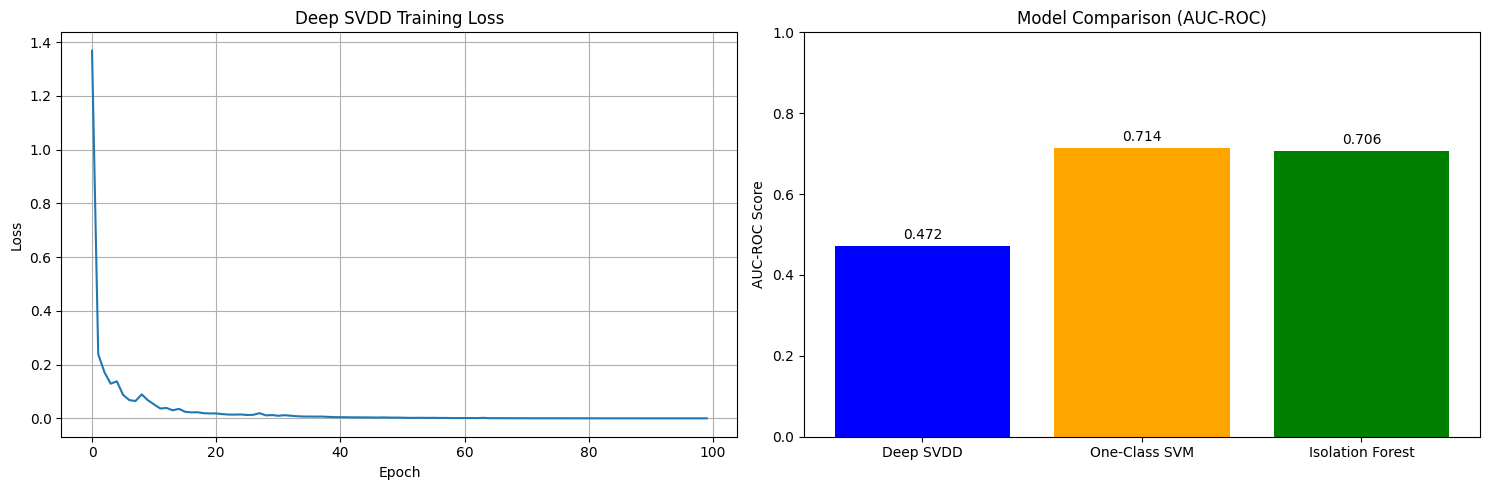


Visualizing sample predictions...


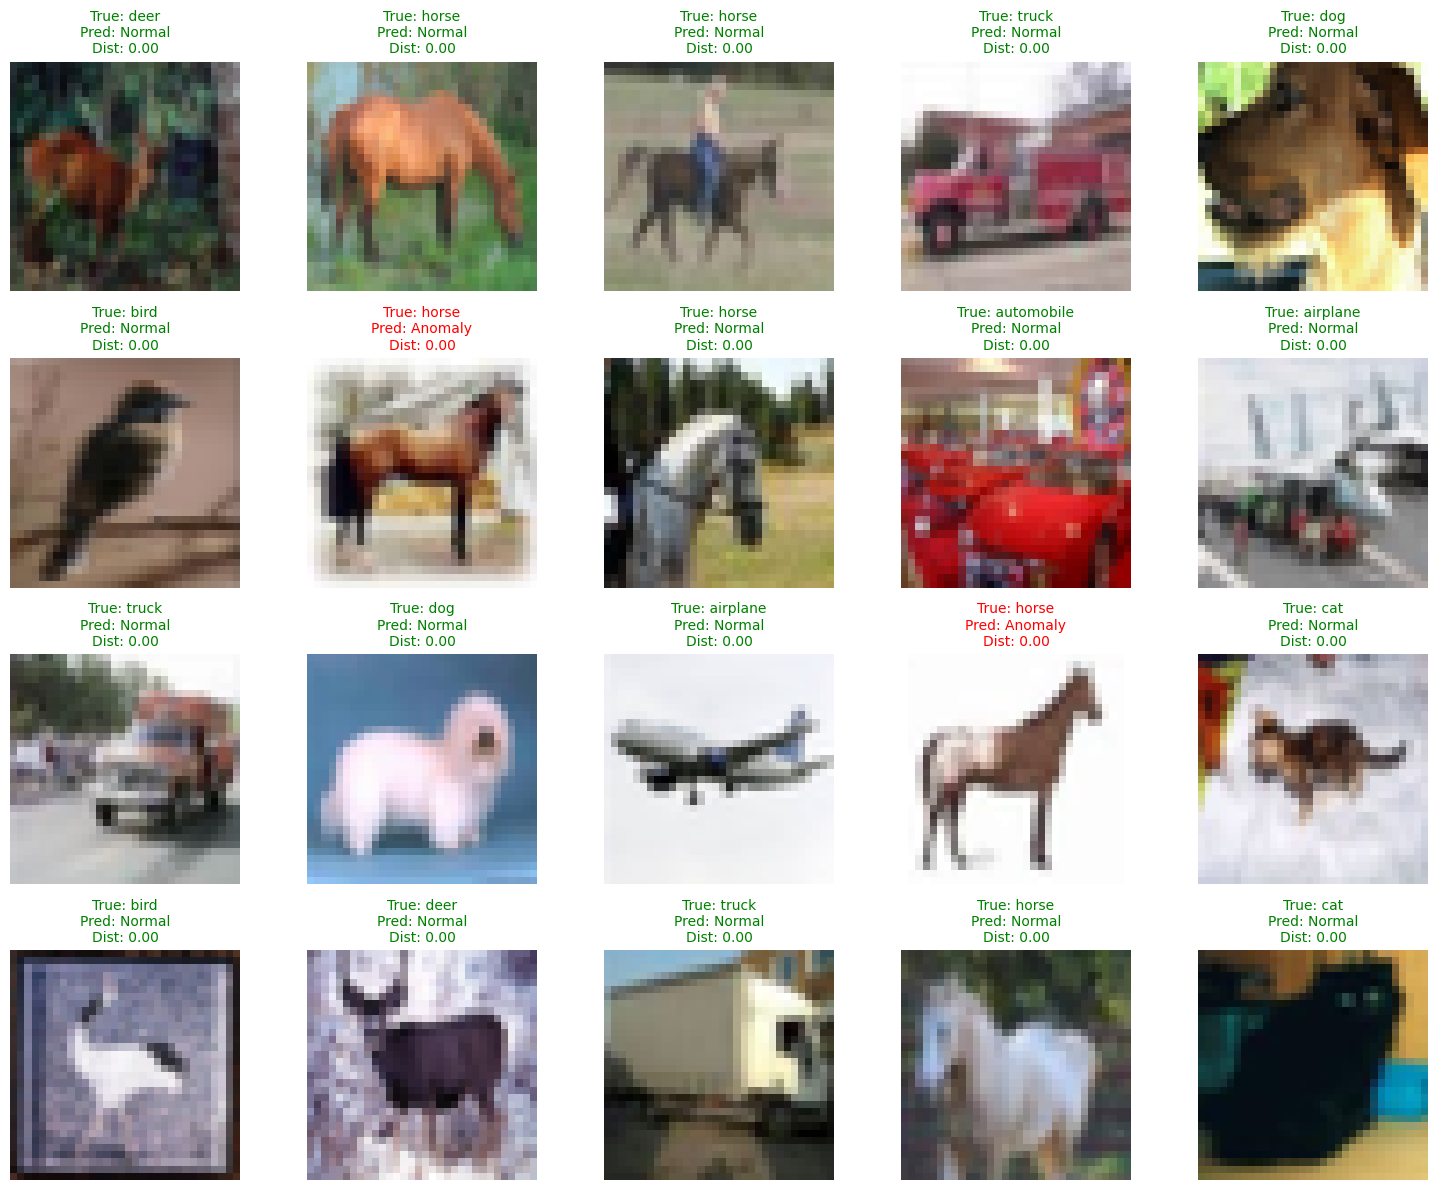


Experiment completed!
Model saved as 'deep_svdd_model.pth'


In [7]:
run_experiment()